## Show results - Test 

In [9]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../figures/'

## Damage cost for each scenario, year and labor type

In [10]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices


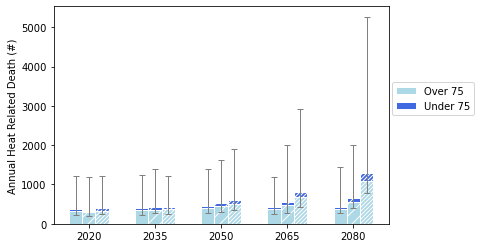

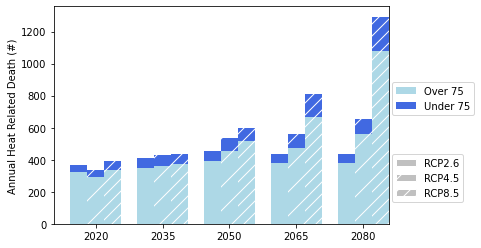

In [11]:
plot_impacts_heat(agg_impacts_mc, 'Annual Heat Related Death (#)', color=['lightblue', 'royalblue'])

#plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2065_werror.pdf']),bbox_inches='tight')


## Spatial Impact

In [12]:
category = 'Over 75'
categories_code = {'Over 75':'O', 'Under 75':'U'}
cm = palettable.scientific.sequential.LaJolla_20.mpl_colormap

directory_exposures = '../../input_data/exposures/'
exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', categories_code[category], '.h5'])
exposures = Exposures()
exposures.read_hdf5(exposures_file)
impact = impacts_mortality.median_matrix_as_impact(median_impact_matrices['RCP85'][2020][category], exposures, unit='Annual Heat Related Death (#)', percentage=False)
#impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

2020-10-27 21:28:53,349 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5


In [14]:
impact = impacts_mortality.median_matrix_as_impact(median_impact_matrices['RCP85'][2020][category], exposures, unit='Annual Heat Related Death (#)', percentage=False, canton='Basel-Stadt')
#impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

## Relative change map

In [18]:
impacts_rel = Impact()
impacts_rel.imp_mat = ImpactsHeatMortality.compute_relative_change(median_impact_matrices['RCP85'][2050][category], median_impact_matrices['RCP85'][2020][category])
#impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

## Canton Impacts

In [19]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices

directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()

agg_impact_zurich = impacts_mortality.calculate_impact_agg_canton('Zürich', exposures)

2020-10-27 21:29:42,810 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5
2020-10-27 21:29:44,775 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-27 21:29:44,776 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-27 21:29:44,776 - climada.entity.exposures.base - INFO - cover not set.
2020-10-27 21:29:44,777 - climada.entity.exposures.base - INFO - category_id not set.
2020-10-27 21:29:44,778 - climada.entity.exposures.base - INFO - region_id not set.
2020-10-27 21:29:44,779 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_U.h5
2020-10-27 21:29:46,869 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-27 21:29:46,870 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-27 21:29:46,870 - climada.entity.exposures.base - INFO - cover not set.
2020-10-27 21:29:46,871 - climada.entity.exposures.base - INFO - category_id not s

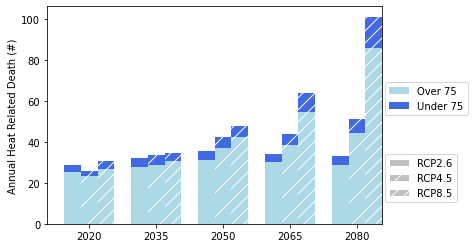

In [20]:
plot_impacts_heat(agg_impact_zurich, 'Annual Heat Related Death (#)',uncertainty=False, color=['lightblue', 'royalblue'])

In [23]:
exposures['Under 75']

,latitude,longitude,if_heat,category,value,geometry,index_right,canton,total_population_canton,daily_deaths
344419,46.150832,5.972096,2.0,Under 75,0.000097,POINT (5.972095716591816 46.15083226217903),20.0,Genève,565674,2.522521
344420,46.148983,5.968262,2.0,Under 75,0.000037,POINT (5.96826201174451 46.14898288609249),20.0,Genève,565674,2.522521
344421,46.148100,5.969580,2.0,Under 75,0.000069,POINT (5.9695803288723 46.14810036009231),20.0,Genève,565674,2.522521
344422,46.149050,5.973438,2.0,Under 75,0.000309,POINT (5.973438219478164 46.14905029092692),20.0,Genève,565674,2.522521
344423,46.159910,5.978325,2.0,Under 75,0.000064,POINT (5.978324974923448 46.15991027871713),20.0,Genève,565674,2.522521
344424,46.156363,5.982304,2.0,Under 75,0.000011,POINT (5.982304162022924 46.15636289736256),20.0,Genève,565674,2.522521
344425,46.149218,5.986379,2.0,Under 75,0.000021,POINT (5.986378794282616 46.14921776393132),20.0,Genève,565674,2.522521
344426,46.166340,5.988512,2.0,Under 75,0.000207,POINT (5.988511792775107 46.16633975735711),20.0,Genève,565674,2.522521
344427,46.166406,5.993690,2.0,Under 75,0.000097,POINT (5.993689674200166 46.16640623282535),20.0,Genève,565674,2.522521
344428,46.168255,5.997525,2.0,Under 75,0.000179,POINT (5.997525468104374 46.16825474635868),20.0,Genève,565674,2.522521
